In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
from sklearn import datasets
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

from qiskit.algorithms.optimizers import ADAM, SPSA, COBYLA
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import TwoLocal, PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.primitives import BackendEstimator, BackendSampler
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient, ParamShiftSamplerGradient

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss
import csv
from IPython.display import clear_output

C:\Users\Admin\AppData\Local\Temp\ipykernel_37828\4172264880.py:8: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import ADAM, SPSA, COBYLA


In [2]:
SEED = 124
qasm_sim = AerSimulator()

# Dataset

In [3]:
my_data = genfromtxt('MNIST_CSV/mnist_train.csv', delimiter=',')

5.0
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.1875, 10.125, 22.9375, 23.375, 0.0], [0.0, 0.0, 39.625, 159.3125, 137.4375, 56.6875, 18.625, 0.0], [0.0, 0.0, 0.0, 64.75, 35.3125, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 83.6875, 75.5, 0.0, 0.0], [0.0, 0.0, 1.4375, 69.8125, 149.0625, 60.75, 0.0, 0.0], [0.0, 11.9375, 116.125, 96.0625, 5.5625, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


<Figure size 640x480 with 0 Axes>

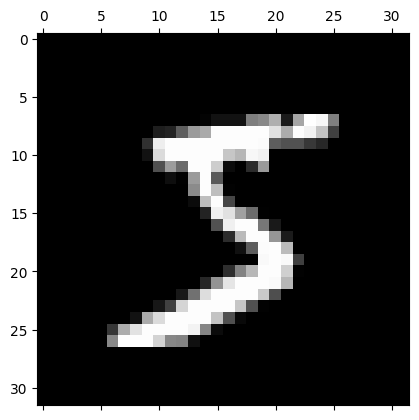

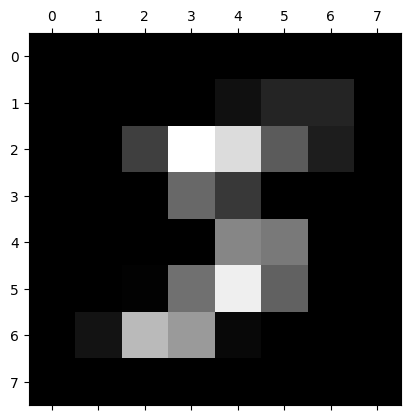

In [4]:
image = []
idx = 0
label = my_data[idx][0]
print(label)
image.append(np.zeros(32))
image.append(np.zeros(32))
for i in range(28):
    row = []
    row.append(0)
    row.append(0)
    for j in range(28):
        row.append(my_data[idx][i*28+j+1])
    row.append(0)
    row.append(0)
    image.append(row)
image.append(np.zeros(32))
image.append(np.zeros(32))
image_shrink = []

for i in range(8):
    row = []
    for j in range(8):
        row.append(sum(image[i*4][j*4:j*4+3])/16+sum(image[i*4+1][j*4:j*4+3])/16
                   +sum(image[i*4+2][j*4:j*4+3])/16+sum(image[i*4+3][j*4:j*4+3])/16)
    image_shrink.append(row)
    
print(image_shrink)
plt.gray()
plt.matshow(image)
plt.matshow(image_shrink)
plt.show()

[[  0.       0.       0.       0.       0.       0.       0.       0.    ]
 [  0.       0.       0.       0.      46.75    43.625    0.       0.    ]
 [  0.       0.       0.      64.1875 175.1875 128.125    0.       0.    ]
 [  0.       0.      33.25   114.3125  13.      63.25    37.8125   0.    ]
 [  0.       0.     134.5      0.       0.      94.4375  22.25     0.    ]
 [  0.       0.     138.8125  53.625  104.9375  40.1875   0.       0.    ]
 [  0.       0.      39.5     87.6875   9.0625   0.       0.       0.    ]
 [  0.       0.       0.       0.       0.       0.       0.       0.    ]]


<Figure size 640x480 with 0 Axes>

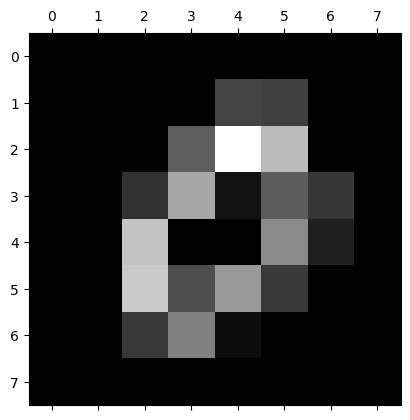

In [5]:
x_list = []
y_list = []
threshold = 200
cnt = 0
for idx in range(len(my_data)):
    image = []
    label = my_data[idx][0]
    if (label==0 or label==1):
            image = np.append(image,np.zeros(64))
            for i in range(28):
                row = my_data[idx][i*28+1:i*28+29]
                row = np.insert(row,0,(0,0))
                row = np.append(row,(0,0))
                image = np.append(image,row)
            image = np.append(image,np.zeros(64))
            image_shrink = []
            for i in range(8):
                row_shrink = []
                for j in range(8):
                    row_shrink = np.append(row_shrink,sum(image[i*4*32+j*4:i*4*32+j*4+3])/16
                                           +sum(image[(i*4+1)*32+j*4:(i*4+1)*32+j*4+3])/16
                                           +sum(image[(i*4+2)*32+j*4:(i*4+2)*32+j*4+3])/16
                                           +sum(image[(i*4+3)*32+j*4:(i*4+3)*32+j*4+3])/16) 
                image_shrink = np.append(image_shrink,row_shrink)  
            x_list.append(image_shrink)
            y_list.append(label)
            cnt = cnt + 1
            if (cnt==threshold):
                break
                
x_img = np.array(x_list)
y = np.array(y_list)
#for i in range(len(x_list)):
#    x[i] = x[i]/sum(x[i])
#    x[i] = np.sqrt(x[i])
    
x_img_real = np.reshape(x_img[0],[8,8])
print(x_img_real)
plt.gray()
plt.matshow(x_img_real)
plt.show()

In [6]:
#Vertical encoding
x = []
for idx in range(len(x_img)):
    row = []
    for i in range(4):
        row = np.append(row,sum(x_img[idx][i*2:i*2+1])+sum(x_img[idx][i*2+8:i*2+9])
                +sum(x_img[idx][i*2+8*2:i*2+8*2+1])+sum(x_img[idx][i*2+8*3:i*2+8*3+1])
                +sum(x_img[idx][i*2+8*4:i*2+8*4+1])+sum(x_img[idx][i*2+8*5:i*2+8*5+1])
                +sum(x_img[idx][i*2+8*6:i*2+8*6+1])+sum(x_img[idx][i*2+8*7:i*2+8*7+1]))
    for i in range(2):
        row = np.append(row,sum(x_img[idx][i*32:i*32+7])+sum(x_img[idx][i*32+8:i*32+8+7])
             +sum(x_img[idx][i*32+8*2:i*32+8*2+7])+sum(x_img[idx][i*32+8*3:i*32+8*3+7]))
    x.append(row)
    
for i in range(len(x_img)):
    x[i] = x[i]/sum(x[i])
    x[i] = np.sqrt(x[i])

x = np.array(x)

In [7]:
test_ratio = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=SEED, stratify=y)
num_classes = 2
num_features = 6

print(f"Train set size: {len(x_train)}")
print(f"Test set size:  {len(x_test)}")

Train set size: 160
Test set size:  40


# Data embedding circuits

In [8]:
def get_zz_feature_map(feature_dim, feature_map_rep, ent):
    return ZZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent)

fmap_zz = get_zz_feature_map(num_features, 2, 'linear')
input_params = fmap_zz.parameters
fmap_zz.decompose().draw()#'mpl', scale=0.7)

┌───┐┌─────────────┐                                          ┌───┐»
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ H ├»
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐└───┘»
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──■──»
     ├───┤├─────────────┤└───┘└──────────────────────────────┘└───┘┌─┴─┐»
q_2: ┤ H ├┤ P(2.0*x[2]) ├──────────────────────────────────────────┤ X ├»
     ├───┤├─────────────┤                                          └───┘»
q_3: ┤ H ├┤ P(2.0*x[3]) ├───────────────────────────────────────────────»
     ├───┤├─────────────┤                                               »
q_4: ┤ H ├┤ P(2.0*x[4]) ├───────────────────────────────────────────────»
     ├───┤├─────────────┤                                               »
q_5: ┤ H ├┤ P(2.0*x[5]) ├───────────────────────────────────────────────»
     └───┘└─────────────┘                                               »
«             ┌─────────────┐                   »
«q_0: ────────┤ P(2.0*x[0]) ├───────────────────»
«             └─────────────┘              ┌───┐»
«q_1: ──────────────────────────────────■──┤ H ├»
«     ┌──────────────────────────────┐┌─┴─┐└───┘»
«q_2: ┤ P(2.0*(π - x[1])*(π - x[2])) ├┤ X ├──■──»
«     └──────────────────────────────┘└───┘┌─┴─┐»
«q_3: ─────────────────────────────────────┤ X ├»
«                                          └───┘»
«q_4: ──────────────────────────────────────────»
«                                               »
«q_5: ──────────────────────────────────────────»
«                                               »
«                                                                          »
«q_0: ──────────────────────────────────■──────────────────────────────────»
«             ┌─────────────┐         ┌─┴─┐┌──────────────────────────────┐»
«q_1: ────────┤ P(2.0*x[1]) ├─────────┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├»
«             └─────────────┘         └───┘└────────────┬───┬─────────────┘»
«q_2: ──────────────────────────────────■───────────────┤ H ├──────────────»
«     ┌──────────────────────────────┐┌─┴─┐             └───┘              »
«q_3: ┤ P(2.0*(π - x[2])*(π - x[3])) ├┤ X ├───────────────■────────────────»
«     └──────────────────────────────┘└───┘             ┌─┴─┐              »
«q_4: ──────────────────────────────────────────────────┤ X ├──────────────»
«                                                       └───┘              »
«q_5: ─────────────────────────────────────────────────────────────────────»
«                                                                          »
«                                                                          »
«q_0: ───────────────■─────────────────────────────────────────────────────»
«                  ┌─┴─┐                                                   »
«q_1: ─────────────┤ X ├────────────────■──────────────────────────────────»
«             ┌────┴───┴────┐         ┌─┴─┐┌──────────────────────────────┐»
«q_2: ────────┤ P(2.0*x[2]) ├─────────┤ X ├┤ P(2.0*(π - x[1])*(π - x[2])) ├»
«             └─────────────┘         └───┘└────────────┬───┬─────────────┘»
«q_3: ──────────────────────────────────■───────────────┤ H ├──────────────»
«     ┌──────────────────────────────┐┌─┴─┐             └───┘              »
«q_4: ┤ P(2.0*(π - x[3])*(π - x[4])) ├┤ X ├───────────────■────────────────»
«     └──────────────────────────────┘└───┘             ┌─┴─┐              »
«q_5: ──────────────────────────────────────────────────┤ X ├──────────────»
«                                                       └───┘              »
«                                                                          »
«q_0: ─────────────────────────────────────────────────────────────────────»
«                                                                          »
«q_1: ───────────────■─────────────────────────────────────────────────────»
«                  ┌─┴─┐                                                   »
«q_2: 

In [9]:
fmap_zz.assign_parameters({k:v for (k,v) in zip(fmap_zz.parameters, x[0])}).decompose().draw()#'mpl', scale=0.7)

┌───┐   ┌──────┐                          ┌───┐  ┌──────┐            »
q_0: ┤ H ├───┤ P(0) ├─────■─────────────────■──┤ H ├──┤ P(0) ├────────────»
     ├───┤┌──┴──────┴─┐ ┌─┴─┐┌───────────┐┌─┴─┐└───┘  └──────┘       ┌───┐»
q_1: ┤ H ├┤ P(0.7933) ├─┤ X ├┤ P(17.247) ├┤ X ├──■────────────────■──┤ H ├»
     ├───┤├───────────┴┐└───┘└───────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐└───┘»
q_2: ┤ H ├┤ P(0.79659) ├───────────────────────┤ X ├┤ P(15.06) ├┤ X ├──■──»
     ├───┤├────────────┤                       └───┘└──────────┘└───┘┌─┴─┐»
q_3: ┤ H ├┤ P(0.33049) ├─────────────────────────────────────────────┤ X ├»
     ├───┤├───────────┬┘                                             └───┘»
q_4: ┤ H ├┤ P(1.1439) ├───────────────────────────────────────────────────»
     ├───┤├───────────┤                                                   »
q_5: ┤ H ├┤ P(1.1482) ├───────────────────────────────────────────────────»
     └───┘└───────────┘                                                   »
«                                                                   »
«q_0: ───────────────■─────────────────────■────────────────────────»
«     ┌───────────┐┌─┴─┐┌───────────┐    ┌─┴─┐                      »
«q_1: ┤ P(0.7933) ├┤ X ├┤ P(17.247) ├────┤ X ├───────■──────────────»
«     └───────────┘└───┘└───┬───┬───┘┌───┴───┴────┐┌─┴─┐┌──────────┐»
«q_2: ───────────────■──────┤ H ├────┤ P(0.79659) ├┤ X ├┤ P(15.06) ├»
«      ┌──────────┐┌─┴─┐    └───┘    └────────────┘└───┘└──┬───┬───┘»
«q_3: ─┤ P(16.33) ├┤ X ├──────■──────────────────────■─────┤ H ├────»
«      └──────────┘└───┘    ┌─┴─┐    ┌───────────┐ ┌─┴─┐   └───┘    »
«q_4: ──────────────────────┤ X ├────┤ P(15.296) ├─┤ X ├─────■──────»
«                           └───┘    └───────────┘ └───┘   ┌─┴─┐    »
«q_5: ─────────────────────────────────────────────────────┤ X ├────»
«                                                          └───┘    »
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_1: ──────■─────────────────────────────────────────────────────────────────»
«         ┌─┴─┐                                                               »
«q_2: ────┤ X ├───────■────────────────────■──────────────────────────────────»
«     ┌───┴───┴────┐┌─┴─┐┌──────────┐    ┌─┴─┐                                »
«q_3: ┤ P(0.33049) ├┤ X ├┤ P(16.33) ├────┤ X ├──────■─────────────────■───────»
«     └────────────┘└───┘└──┬───┬───┘┌───┴───┴───┐┌─┴─┐┌───────────┐┌─┴─┐     »
«q_4: ────────────────■─────┤ H ├────┤ P(1.1439) ├┤ X ├┤ P(15.296) ├┤ X ├──■──»
«     ┌───────────┐ ┌─┴─┐   ├───┤    ├───────────┤└───┘└───────────┘└───┘┌─┴─┐»
«q_5: ┤ P(13.195) ├─┤ X ├───┤ H ├────┤ P(1.1482) ├───────────────────────┤ X ├»
«     └───────────┘ └───┘   └───┘    └───────────┘                       └───┘»
«                       
«q_0: ──────────────────
«                       
«q_1: ──────────────────
«                       
«q_2: ──────────────────
«                       
«q_3: ──────────────────
«                       
«q_4: ───────────────■──
«     ┌───────────┐┌─┴─┐
«q_5: ┤ P(13.195) ├┤ X ├
«     └───────────┘└───┘

# Ansatz

In [25]:
def get_two_locals(feature_dim, rotations, var_form_rep, ent):
    return TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)

ansatz = get_two_locals(num_features, ['ry', 'rz'], 2, 'linear')
weights_params = ansatz.parameters
ansatz.decompose().draw()#'mpl', scale=0.7)

┌──────────┐ ┌──────────┐     ┌───────────┐┌───────────┐             »
q_0: ┤ Ry(θ[0]) ├─┤ Rz(θ[6]) ├──■──┤ Ry(θ[12]) ├┤ Rz(θ[18]) ├─────────────»
     ├──────────┤ ├──────────┤┌─┴─┐└───────────┘├───────────┤┌───────────┐»
q_1: ┤ Ry(θ[1]) ├─┤ Rz(θ[7]) ├┤ X ├──────■──────┤ Ry(θ[13]) ├┤ Rz(θ[19]) ├»
     ├──────────┤ ├──────────┤└───┘    ┌─┴─┐    └───────────┘├───────────┤»
q_2: ┤ Ry(θ[2]) ├─┤ Rz(θ[8]) ├─────────┤ X ├──────────■──────┤ Ry(θ[14]) ├»
     ├──────────┤ ├──────────┤         └───┘        ┌─┴─┐    └───────────┘»
q_3: ┤ Ry(θ[3]) ├─┤ Rz(θ[9]) ├──────────────────────┤ X ├──────────■──────»
     ├──────────┤┌┴──────────┤                      └───┘        ┌─┴─┐    »
q_4: ┤ Ry(θ[4]) ├┤ Rz(θ[10]) ├───────────────────────────────────┤ X ├────»
     ├──────────┤├───────────┤                                   └───┘    »
q_5: ┤ Ry(θ[5]) ├┤ Rz(θ[11]) ├────────────────────────────────────────────»
     └──────────┘└───────────┘                                            »
«                  ┌───────────┐┌───────────┐                          »
«q_0: ──────■──────┤ Ry(θ[24]) ├┤ Rz(θ[30]) ├──────────────────────────»
«         ┌─┴─┐    └───────────┘├───────────┤┌───────────┐             »
«q_1: ────┤ X ├──────────■──────┤ Ry(θ[25]) ├┤ Rz(θ[31]) ├─────────────»
«     ┌───┴───┴───┐    ┌─┴─┐    └───────────┘├───────────┤┌───────────┐»
«q_2: ┤ Rz(θ[20]) ├────┤ X ├──────────■──────┤ Ry(θ[26]) ├┤ Rz(θ[32]) ├»
«     ├───────────┤┌───┴───┴───┐    ┌─┴─┐    └───────────┘├───────────┤»
«q_3: ┤ Ry(θ[15]) ├┤ Rz(θ[21]) ├────┤ X ├──────────■──────┤ Ry(θ[27]) ├»
«     └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐    └───────────┘»
«q_4: ──────■──────┤ Ry(θ[16]) ├┤ Rz(θ[22]) ├────┤ X ├──────────■──────»
«         ┌─┴─┐    ├───────────┤├───────────┤    └───┘        ┌─┴─┐    »
«q_5: ────┤ X ├────┤ Ry(θ[17]) ├┤ Rz(θ[23]) ├─────────────────┤ X ├────»
«         └───┘    └───────────┘└───────────┘                 └───┘    »
«                               
«q_0: ──────────────────────────
«                               
«q_1: ──────────────────────────
«                               
«q_2: ──────────────────────────
«     ┌───────────┐             
«q_3: ┤ Rz(θ[33]) ├─────────────
«     ├───────────┤┌───────────┐
«q_4: ┤ Ry(θ[28]) ├┤ Rz(θ[34]) ├
«     ├───────────┤├───────────┤
«q_5: ┤ Ry(θ[29]) ├┤ Rz(θ[35]) ├
«     └───────────┘└───────────┘

In [26]:
weights = np.random.random(len(ansatz.parameters))
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw()#'mpl', scale=0.7)

┌────────────┐┌─────────────┐      ┌─────────────┐┌─────────────┐»
q_0: ─┤ Ry(0.9975) ├┤ Rz(0.11392) ├───■──┤ Ry(0.83726) ├┤ Rz(0.83982) ├»
     ┌┴────────────┤├─────────────┤ ┌─┴─┐└─────────────┘├─────────────┤»
q_1: ┤ Ry(0.23934) ├┤ Rz(0.72424) ├─┤ X ├───────■───────┤ Ry(0.19286) ├»
     ├─────────────┤├─────────────┤ └───┘     ┌─┴─┐     └─────────────┘»
q_2: ┤ Ry(0.85973) ├┤ Rz(0.76469) ├───────────┤ X ├────────────■───────»
     ├─────────────┤├─────────────┤           └───┘          ┌─┴─┐     »
q_3: ┤ Ry(0.63298) ├┤ Rz(0.72903) ├──────────────────────────┤ X ├─────»
     ├─────────────┤├─────────────┤                          └───┘     »
q_4: ┤ Ry(0.50181) ├┤ Rz(0.89653) ├────────────────────────────────────»
     └┬────────────┤├─────────────┴┐                                   »
q_5: ─┤ Ry(0.5652) ├┤ Rz(0.056652) ├───────────────────────────────────»
      └────────────┘└──────────────┘                                   »
«                                   ┌─────────────┐┌─────────────┐»
«q_0: ──────────────────────■───────┤ Ry(0.44253) ├┤ Rz(0.10676) ├»
«     ┌─────────────┐     ┌─┴─┐     └─────────────┘├─────────────┤»
«q_1: ┤ Rz(0.37623) ├─────┤ X ├────────────■───────┤ Ry(0.28175) ├»
«     ├─────────────┤┌────┴───┴────┐     ┌─┴─┐     └─────────────┘»
«q_2: ┤ Ry(0.33571) ├┤ Rz(0.60125) ├─────┤ X ├────────────■───────»
«     └─────────────┘├─────────────┤┌────┴───┴────┐     ┌─┴─┐     »
«q_3: ───────■───────┤ Ry(0.73524) ├┤ Rz(0.10832) ├─────┤ X ├─────»
«          ┌─┴─┐     └─────────────┘├─────────────┤┌────┴───┴────┐»
«q_4: ─────┤ X ├────────────■───────┤ Ry(0.59277) ├┤ Rz(0.93417) ├»
«          └───┘          ┌─┴─┐     ├─────────────┤├─────────────┤»
«q_5: ────────────────────┤ X ├─────┤ Ry(0.81112) ├┤ Rz(0.79891) ├»
«                         └───┘     └─────────────┘└─────────────┘»
«                                                                  
«q_0: ─────────────────────────────────────────────────────────────
«     ┌──────────────┐                                             
«q_1: ┤ Rz(0.054412) ├─────────────────────────────────────────────
«     ├─────────────┬┘┌─────────────┐                              
«q_2: ┤ Ry(0.65085) ├─┤ Rz(0.86777) ├──────────────────────────────
«     └─────────────┘ ├─────────────┤┌─────────────┐               
«q_3: ───────■────────┤ Ry(0.19152) ├┤ Rz(0.58588) ├───────────────
«          ┌─┴─┐      └─────────────┘├─────────────┤┌─────────────┐
«q_4: ─────┤ X ├─────────────■───────┤ Ry(0.88596) ├┤ Rz(0.45723) ├
«          └───┘           ┌─┴─┐     ├─────────────┤├─────────────┤
«q_5: ─────────────────────┤ X ├─────┤ Ry(0.77014) ├┤ Rz(0.69029) ├
«                          └───┘     └─────────────┘└─────────────┘

In [27]:
var_circuit = fmap_zz.compose(ansatz)
var_circuit.draw()#'mpl', scale=0.7)

┌──────────────────────────────────────────────┐»
q_0: ┤0                                             ├»
     │                                              │»
q_1: ┤1                                             ├»
     │                                              │»
q_2: ┤2                                             ├»
     │  ZZFeatureMap(x[0],x[1],x[2],x[3],x[4],x[5]) │»
q_3: ┤3                                             ├»
     │                                              │»
q_4: ┤4                                             ├»
     │                                              │»
q_5: ┤5                                             ├»
     └──────────────────────────────────────────────┘»
«     ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                                                                                                                                         ├
«     │                                                                                                                                                                                                                          │
«q_1: ┤1                                                                                                                                                                                                                         ├
«     │                                                                                                                                                                                                                          │
«q_2: ┤2                                                                                                                                                                                                                         ├
«     │  TwoLocal(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9],θ[10],θ[11],θ[12],θ[13],θ[14],θ[15],θ[16],θ[17],θ[18],θ[19],θ[20],θ[21],θ[22],θ[23],θ[24],θ[25],θ[26],θ[27],θ[28],θ[29],θ[30],θ[31],θ[32],θ[33],θ[34],θ[35]) │
«q_3: ┤3                                                                                                                                                                                                                         ├
«     │                                                                                                                                                                                                                          │
«q_4: ┤4                                                                                                                                                                                                                         ├
«     │                                                                                                                                                                                                                          │
«q_5: ┤5                                                                                                                                                                                                                         ├
«     └──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

# Primitives

For info, see https://docs.quantum.ibm.com/run/primitives

In [28]:
# for qiskit_ibm_runtime.Options, see https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.Options
options = {}
sampler = BackendSampler(backend=qasm_sim, options=options)
estimator = BackendEstimator(backend=qasm_sim, options=options)

# Quantum Neural Network

## SamplerQNN

In [29]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [30]:
var_circuit_with_meas = var_circuit.copy()
var_circuit_with_meas.measure_all()

In [31]:
paramShiftSampGrad = ParamShiftSamplerGradient(sampler=sampler)

sampler_qnn = SamplerQNN(sampler=sampler,
                         circuit=var_circuit_with_meas,
                         input_params=input_params,     # if your embedding strategy is not a parametrized circuit
                                                        # (e.g. amplitude encoding) you will have to do some extra work!
                         weight_params=weights_params,  # if you train your embedding as well, the trainable
                                                        # parameters of the embedding must be added
                         interpret=one_qubit_binary,
                         output_shape=2,
                         gradient=paramShiftSampGrad)

# Train a Neural Network Classifier

In [32]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels), dtype=int)[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

print(f"Label {y_train[2]} converted to {y_train_1h[2]}")
print(f"Label {y_train[0]} converted to {y_train_1h[0]}")

Label 1.0 converted to [0 1]
Label 0.0 converted to [1 0]


In [33]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Training loss vs epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Training loss")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    
def spsa_callback(nfev, params, fval=2, stepsize=2, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global spsa_loss_recorder
    

    if (nfev % 3) == 0:
        spsa_loss_recorder.append(fval)
        #print(f"SPSA Epoch {len(spsa_loss_recorder)}: {fval:.5f}")

In [34]:
max_itr = 300
spsa_opt = SPSA(maxiter=max_itr, callback=spsa_callback)
initial_point = np.random.random((len(ansatz.parameters),))
classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn,
    loss=CrossEntropyLoss(),
    one_hot=True,
    optimizer=COBYLA(maxiter=max_itr),  # Set max iterations here
    callback=callback_graph,
    initial_point=initial_point,
)

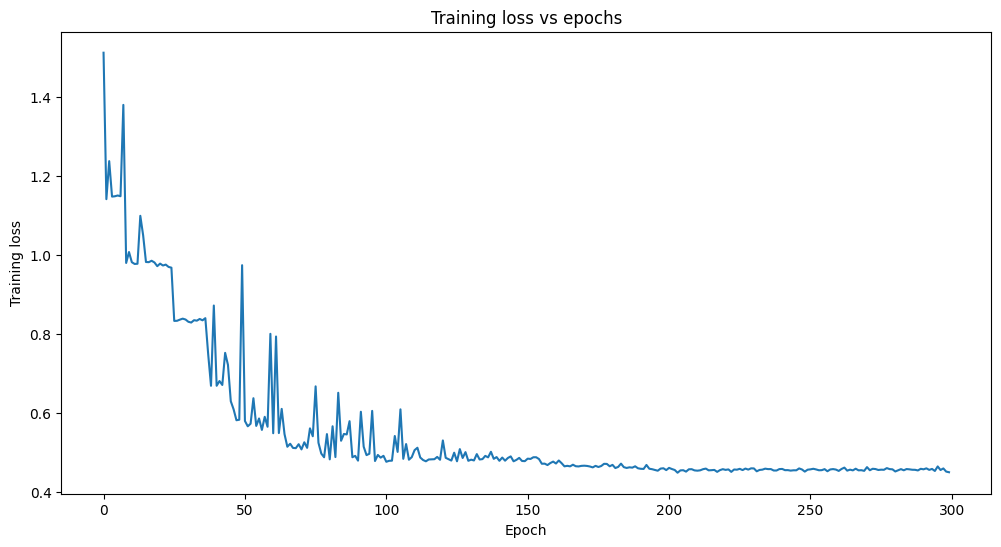

In [35]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
print(x_train)
classifier = classifier.fit(x_train, y_train_1h)

In [38]:
score_train = classifier.score(x_train, y_train_1h)
score_test = classifier.score(x_test, y_test_1h)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.8375
Score on the test set 0.925
